In [1]:
from datasets import generate_x_y_data_v1 as generate_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sample_x, sample_y = generate_data(isTrain=True, batch_size=3)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

Dimensions of the dataset for 3 X and 3 Y training examples : 
(10, 3, 2)
(10, 3, 2)
(seq_length, batch_size, output_dim)


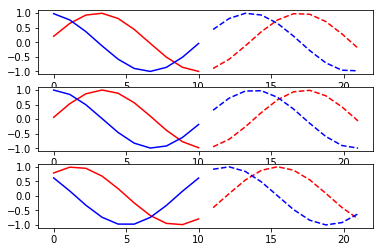

In [3]:
import math

plt.figure()
x_axis = np.linspace(0, 10, 10)
for i in range(3):
    plt.subplot(311+i)
    plt.yticks(np.linspace(-1,1,5))
    plt.plot(x_axis, sample_x[:, i, 0], 'r', x_axis, sample_x[:, i, 1], 'b')
    plt.plot(x_axis+11, sample_y[:, i, 0], 'r--', x_axis+11, sample_y[:, i, 1], 'b--')

plt.show()

In [4]:
from model.decoders import Decoder
from model.encoders import Encoder
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Internal neural network parameters
# Time series will have the same past and future (to be predicted) lenght.
seq_length = sample_x.shape[1]
batch_size = 5  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = input_dim = sample_x.shape[-1]
hidden_dim = 12  # Count of hidden neurons in the recurrent units.
# Number of stacked recurrent cells, on the neural depth axis.
layers_stacked_count = 2

# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.
# How many times we perform a training step (therefore how many times we
# show a batch).
nb_iters = 150
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [5]:
test_encoder = Encoder(input_dim, hidden_dim, number_of_layers=layers_stacked_count)

# initialize the hidden state(num_layers, batch_size, hidden_size).
hidden = (autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))),
          autograd.Variable(torch.randn((layers_stacked_count, batch_size, hidden_dim))))

sample_x, sample_y = generate_data(isTrain=True, batch_size=batch_size)
input_x = autograd.Variable(torch.FloatTensor(sample_x), requires_grad=False)

print(test_encoder)

Encoder (
  (encoder): LSTM(2, 12, num_layers=2)
)


In [6]:
encoder_output, encoder_state = test_encoder(input_x,hidden)
print(encoder_output[-1])

Variable containing:

Columns 0 to 9 
-0.0568 -0.1679  0.1500  0.0230 -0.1483  0.1639  0.0000 -0.1610 -0.0119  0.0729
-0.0896 -0.1135  0.1754  0.0572 -0.1335  0.1290 -0.0138 -0.1537 -0.0139  0.0696
-0.1318 -0.0878  0.2104  0.0615 -0.1318  0.0688  0.0073 -0.1262 -0.0372  0.0515
-0.1256 -0.0860  0.2030  0.0799 -0.1217  0.0833 -0.0028 -0.1321 -0.0296  0.0594
-0.0902 -0.1074  0.1766  0.0626 -0.1352  0.1279 -0.0205 -0.1498 -0.0224  0.0731

Columns 10 to 11 
 0.1736 -0.1944
 0.1420 -0.1693
 0.1379 -0.1687
 0.1447 -0.1683
 0.1299 -0.1662
[torch.FloatTensor of size 5x12]



In [7]:
test_decoder = Decoder(hidden_dim, hidden_dim, output_dim, number_of_layers=layers_stacked_count)
print(test_decoder)

Decoder (
  (decoder): LSTM(12, 12, num_layers=2)
  (linear): Linear (12 -> 2)
)


In [8]:
decoder_input = torch.unsqueeze(encoder_output[-1], 0)

def forward_decoder(next_input, length, next_hidden):
    output = []
    for _ in range(length):
        decoder_output, next_input, next_hidden = test_decoder(next_input, next_hidden)
        output += [decoder_output]
    
    return output

predicts = forward_decoder(decoder_input, 10, hidden)

In [9]:
outputs = torch.stack(predicts, 1).squeeze()
print(outputs)

Variable containing:
-0.1482 -0.4090
-0.1828 -0.3965
-0.2233 -0.4161
-0.2437 -0.4216
-0.2511 -0.4211
-0.2522 -0.4184
-0.2509 -0.4153
-0.2491 -0.4126
-0.2474 -0.4104
-0.2459 -0.4087
[torch.FloatTensor of size 10x2]



In [10]:
criterion = nn.MSELoss()

